In [16]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [17]:
# Définir la transformation des données, à la fois pour convenir au ResNet ("Resize(224)")
# et pour augmenter le dataset tout en l'équilibrant
data_transforms = transforms.Compose([
    # Suppression du bandeau vertical sur les images originelles
    transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Utiliser un GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Chemins vers le dataset
data_dir_training = 'Dataset\Dataset\Training_data'
data_dir_testing = 'Dataset\Dataset\Testing_data'

In [18]:
animal_classes = ['badger', 'bird', 'cat', 'fox', 'mouse', 'rabbit']

# Do only resizing and normalization
def create_dataset(data_dir, transform):
    transformed_images = []
    for class_name in animal_classes:
        for img in os.listdir(os.path.join(data_dir, class_name)):
            img_path = os.path.join(data_dir, class_name, img)
            image = Image.open(img_path)
            resized_img = transform(image)
            transformed_images.append((resized_img, class_name))
    return transformed_images

# Create datasets for each type of transformation
initial_training_dataset = create_dataset(data_dir_training, data_transforms)
testing_datset = create_dataset(data_dir_testing, data_transforms)

In [11]:
class AnimalDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_tensor = self.dataframe[idx][0]
        label = self.dataframe[idx][1]

        # Convert label to torch.long
        label = torch.tensor(label, dtype=torch.long)

        return image_tensor, label

In [19]:
# Parameters
animal_classes = ['badger', 'bird', 'cat', 'fox', 'mouse', 'rabbit']
num_classes = len(animal_classes)
batch_size = 32
learning_rate = 0.001
num_epochs = 40

label_mapping = {label: idx for idx, label in enumerate(animal_classes)}
mapped_initial_dataset = [(tensor, label_mapping[label]) for tensor, label in initial_training_dataset]

initial_train_df, initial_val_df = train_test_split(mapped_initial_dataset, test_size=0.2)

# Create dataset objects
initial_train_dataset = AnimalDataset(dataframe=initial_train_df)
initial_val_dataset = AnimalDataset(dataframe=initial_val_df)

initial_train_loader = DataLoader(initial_train_dataset, batch_size=batch_size, shuffle=True)
initial_val_loader = DataLoader(initial_val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Load pre-trained ResNet model and modify it
initial_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
initial_model.fc = nn.Linear(initial_model.fc.in_features, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(initial_model.parameters(), lr=learning_rate)

## Data augmentation

We don't have plenty of data, and especially for certain classes (unbalanced dataset). 

In order to correct that, we thought of **data augmentation**. This could solve both issues. 

*Data quantity* : data augmentation can increase the number of data available for training, enabling better learning and generalization.

*Unbalanced dataset* : by augmenting more frequently under-represented classes, this would also enable us to balance the dataset. 

**Augmented images need to be only used during training**.


In [20]:
def random_rotation(img): # called in images_random_affine
    # Choose a random angle from -10 to -5 or 5 to 10 degrees
    if random.random() > 0.5:
        angle = random.uniform(-10, -5)
    else:
        angle = random.uniform(5, 10)
    return transforms.functional.rotate(img, angle)

# Définir la transformation des données, à la fois pour convenir au ResNet ("Resize(224)")
# et pour augmenter le dataset tout en l'équilibrant
data_augmentation_transforms = {
    # Data augmentation techniques,
    'images_horizontally_flipped': transforms.Compose([
        transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
        transforms.RandomHorizontalFlip(1),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'images_random_affine': transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.crop(img, top=0, left=0, height=img.height - 32, width=img.width)),
    transforms.Lambda(random_rotation),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'images_random_perspective': transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Utiliser un GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Chemins vers le dataset
data_dir_training = 'Dataset\Dataset\Training_data'

In [21]:
class_occurences_training_initial = {
    'badger' : 0,
    'bird': 0,
    'cat': 0,
    'fox': 0,
    'mouse': 0,
    'rabbit': 0
}

for img in initial_training_dataset:
    class_occurences_training_initial[str(img[1])] += 1

In [22]:
class_occurences_max = max(class_occurences_training_initial.values())

class_augmentation_probabilities= {
animal: min(1, (class_occurences_max - class_occurences_training_initial[animal]) / (3 * class_occurences_training_initial[animal]))
    for animal in animal_classes
}

images_to_horizontally_flip = {}
images_to_random_affine = {}
images_to_random_perspective = {}

for class_name, probability in class_augmentation_probabilities.items():
    class_images = [img for img in os.listdir(os.path.join(data_dir_training, class_name)) if random.random() < probability]
    images_to_horizontally_flip[class_name] = class_images

for class_name, probability in class_augmentation_probabilities.items():
    class_images = [img for img in os.listdir(os.path.join(data_dir_training, class_name)) if random.random() < probability]
    images_to_random_affine[class_name] = class_images
    
for class_name, probability in class_augmentation_probabilities.items():
    class_images = [img for img in os.listdir(os.path.join(data_dir_training, class_name)) if random.random() < probability]
    images_to_random_perspective[class_name] = class_images

# Now, create datasets for each transformation with filtered images
def create_transformed_dataset(transform, images_list):
    transformed_images = []
    for class_name, images in images_list.items():
        for img in images:
            img_path = os.path.join(data_dir_training, class_name, img)
            image = Image.open(img_path)  # Load the image
            transformed_img = transform(image)
            transformed_images.append((transformed_img, class_name))
    return transformed_images

# Create datasets for each type of transformation
horizontal_flip_dataset = create_transformed_dataset(data_augmentation_transforms['images_horizontally_flipped'], images_to_horizontally_flip)
affine_transform_dataset = create_transformed_dataset(data_augmentation_transforms['images_random_affine'], images_to_random_affine)
perspective_transform_dataset = create_transformed_dataset(data_augmentation_transforms['images_random_perspective'], images_to_random_perspective)

In [10]:
# Function to convert a tensor to a PIL image
def tensor_to_pil(tensor):
    # Inverse normalization of the image
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    # Inverse normalization of the tensor
    inv_tensor = inv_normalize(tensor)
    # Clamp the image data to valid range (0-1)
    inv_tensor = inv_tensor.clamp(0, 1)
    # Convert to PIL Image
    pil_image = transforms.ToPILImage()(inv_tensor)
    return pil_image

In [11]:
def plot_images(num_images, dataset, delta):

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 4))

    for i in range(num_images):
        image_tensor, class_name = dataset[delta*i] 
        image_pil = tensor_to_pil(image_tensor)
        # Plot each image
        ax = axes[i]
        ax.imshow(image_pil)
        ax.set_title(f"Class: {class_name}")
        ax.axis('off')

    plt.show()

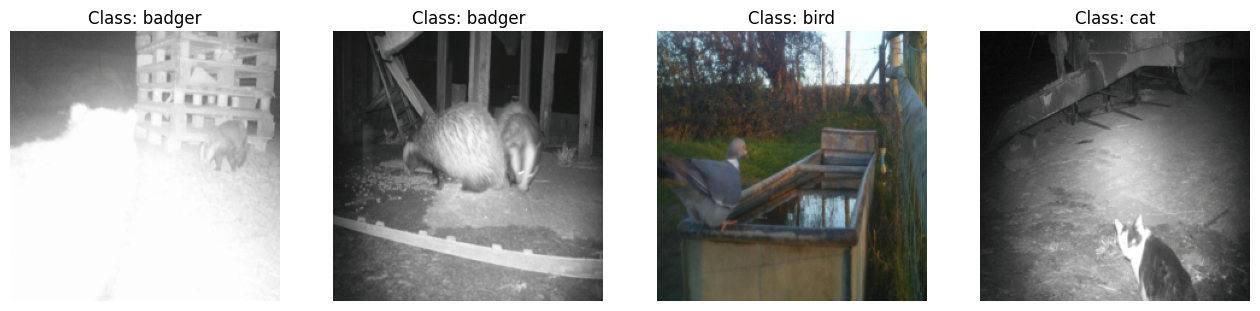

In [12]:
plot_images(4, horizontal_flip_dataset, 200)

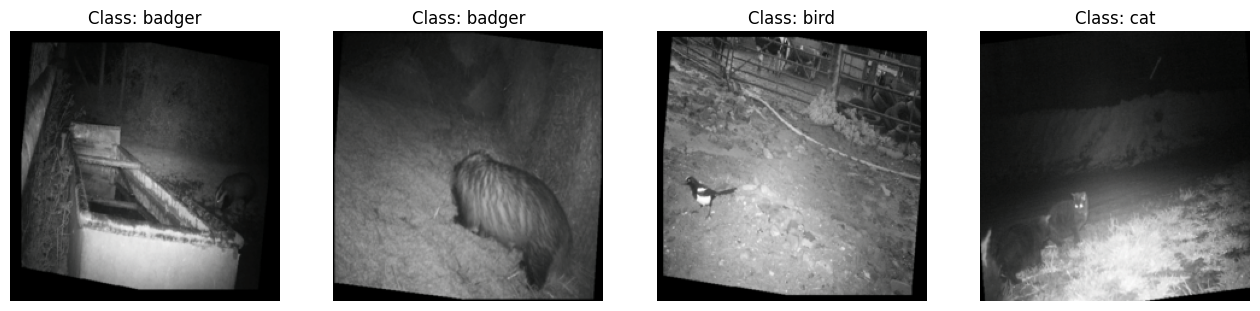

In [13]:
plot_images(4, affine_transform_dataset, 200)

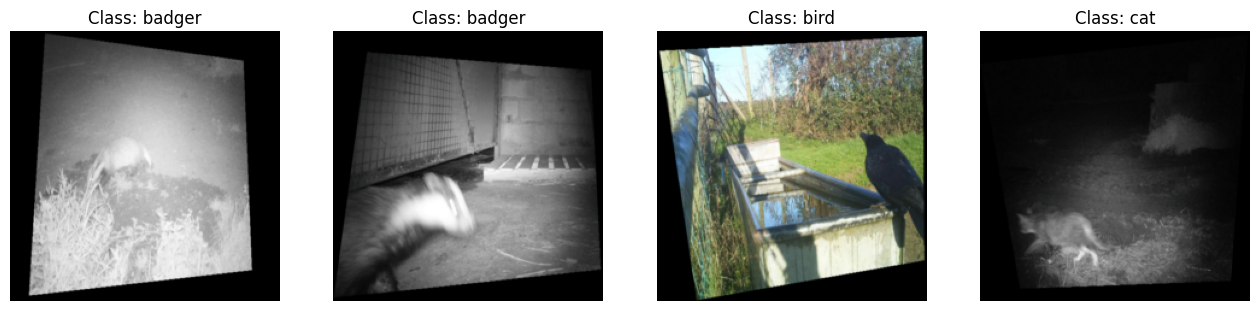

In [30]:
plot_images(4, perspective_transform_dataset, 200)

In [14]:
augmented_dataset = initial_training_dataset + horizontal_flip_dataset + affine_transform_dataset + perspective_transform_dataset

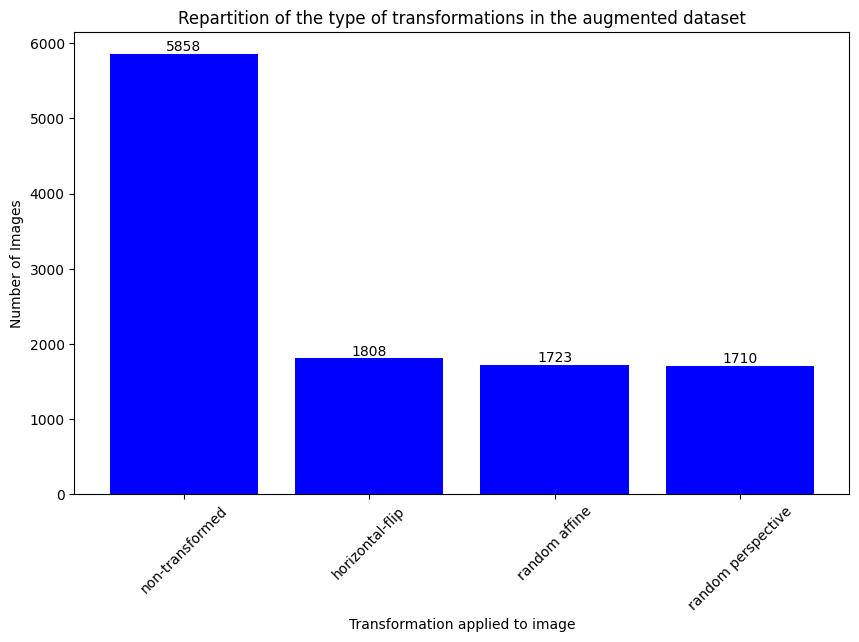

In [23]:
import matplotlib.pyplot as plt

# Dataset lengths
transformations_occurrences = {
    "non-transformed": len(initial_training_dataset),
    "horizontal-flip": len(horizontal_flip_dataset),
    "random affine": len(affine_transform_dataset),
    "random perspective": len(perspective_transform_dataset)
}

# Extracting dataset names and their lengths
datasets = list(transformations_occurrences.keys())
lengths = list(transformations_occurrences.values())

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(datasets, lengths, color='blue')
plt.xlabel('Transformation applied to image')
plt.ylabel('Number of Images')
plt.title('Repartition of the type of transformations in the augmented dataset')
plt.xticks(rotation=45)

# Adding the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

In [16]:
class_occurences_training_augmented = {
    'badger' : 0,
    'bird': 0,
    'cat': 0,
    'fox': 0,
    'mouse': 0,
    'rabbit': 0
}

for img in augmented_dataset:
    class_occurences_training_augmented[str(img[1])] += 1

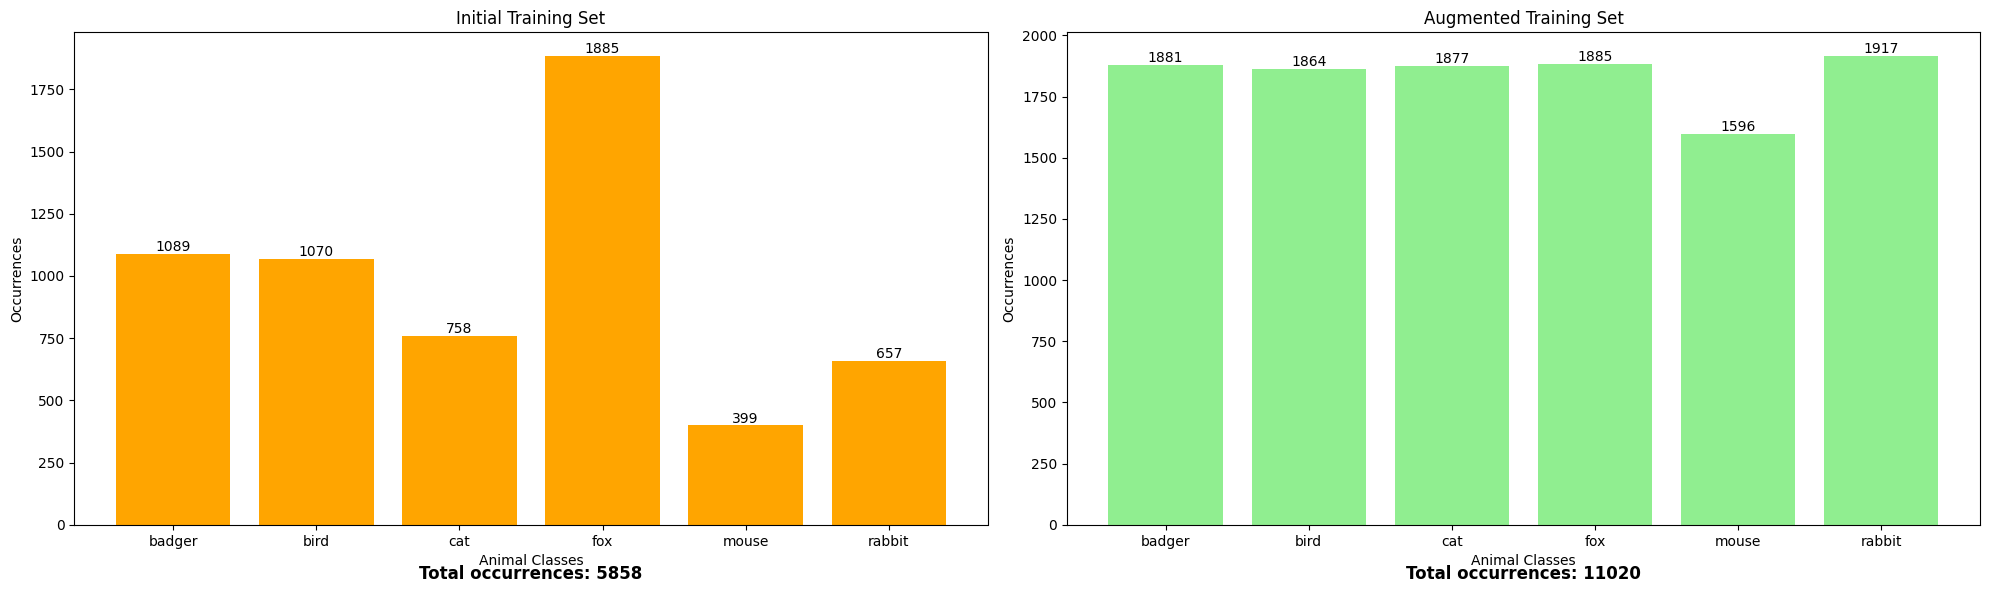

In [17]:
occurrences_initial = list(class_occurences_training_initial.values())
occurrences_augmented = list(class_occurences_training_augmented.values())

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

bars_initial = axes[0].bar(animal_classes, occurrences_initial, color='orange')
axes[0].set_title('Initial Training Set')
axes[0].set_xlabel('Animal Classes')
axes[0].set_ylabel('Occurrences')
total_initial = sum(occurrences_initial)
axes[0].text(0.5, -0.1, f'Total occurrences: {total_initial}', ha='center', va='center', 
             transform=axes[0].transAxes, fontsize=12, fontweight='bold')
for bar in bars_initial:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

bars_augmented = axes[1].bar(animal_classes, occurrences_augmented, color='lightgreen')
axes[1].set_title('Augmented Training Set')
axes[1].set_xlabel('Animal Classes')
axes[1].set_ylabel('Occurrences')
total_augmented = sum(occurrences_augmented)
axes[1].text(0.5, -0.1, f'Total occurrences: {total_augmented}', ha='center', va='center', 
             transform=axes[1].transAxes, fontsize=12, fontweight='bold')
for bar in bars_augmented:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()

In [20]:
# Convert labels to numerical values and ensure they are integers
label_mapping = {label: idx for idx, label in enumerate(animal_classes)}
mapped_augmented_dataset = [(tensor, label_mapping[label]) for tensor, label in augmented_dataset]

train_df, val_df = train_test_split(mapped_augmented_dataset, test_size=0.2)

# Create dataset objects
train_dataset = AnimalDataset(dataframe=train_df)
val_dataset = AnimalDataset(dataframe=val_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [21]:
# Load pre-trained ResNet model and modify it
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

In [26]:
# Set up TensorBoard writer
writer = SummaryWriter()

# Variables for early stopping
best_val_loss = float('inf')
patience = 7  # Number of epochs to wait before stopping training
counter = 0

# Define the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_id, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Write training loss to TensorBoard
        total_train_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

        # Print training loss per batch
        print(f'Training: [Epoch {epoch + 1}/{num_epochs}, Batch {batch_id + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Validation loop
    with torch.no_grad():
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        for batch_id, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

            # Calculate accuracy
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

            # Print validation loss per batch
            print(f'Validation: [Epoch {epoch + 1}/{num_epochs}, Batch {batch_id + 1}/{len(val_loader)}], Loss: {val_loss.item():.4f})

        # Calculate accuracy for validation set
        val_accuracy = 100 * correct_val / total_val
        average_val_loss = total_val_loss / len(val_loader)

    # Early stopping check
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        counter = 0
    else:
        counter += 1

    # Consider the gap between training and validation losses
    if counter >= patience and (total_train_loss / len(train_loader)) > 1.2 * average_val_loss:
        print(f'Early stopping at epoch {epoch + 1} due to no improvement in validation loss.')
        break

    # Write accuracy and loss to TensorBoard
    writer.add_scalar('Loss/Train', total_train_loss / len(train_loader), epoch)
    writer.add_scalar('Accuracy/Train', 100 * correct_train / total_train, epoch)
    writer.add_scalar('Loss/Validation', average_val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

# Save the model if needed
torch.save(model.state_dict(), 'fine_tuned_model.pth')


Training: [Epoch 1/40, Batch 1/276], Loss: 0.4416
Training: [Epoch 1/40, Batch 2/276], Loss: 0.4907
Training: [Epoch 1/40, Batch 3/276], Loss: 0.4403
Training: [Epoch 1/40, Batch 4/276], Loss: 0.7929
Training: [Epoch 1/40, Batch 5/276], Loss: 1.0829
Training: [Epoch 1/40, Batch 6/276], Loss: 1.1736
Training: [Epoch 1/40, Batch 7/276], Loss: 0.4975
Training: [Epoch 1/40, Batch 8/276], Loss: 0.5175
Training: [Epoch 1/40, Batch 9/276], Loss: 0.5527
Training: [Epoch 1/40, Batch 10/276], Loss: 0.9611
Training: [Epoch 1/40, Batch 11/276], Loss: 0.8472
Training: [Epoch 1/40, Batch 12/276], Loss: 0.5273
Training: [Epoch 1/40, Batch 13/276], Loss: 0.5769
Training: [Epoch 1/40, Batch 14/276], Loss: 0.6910
Training: [Epoch 1/40, Batch 15/276], Loss: 0.9097
Training: [Epoch 1/40, Batch 16/276], Loss: 0.6771
Training: [Epoch 1/40, Batch 17/276], Loss: 0.8710
Training: [Epoch 1/40, Batch 18/276], Loss: 0.9940
Training: [Epoch 1/40, Batch 19/276], Loss: 0.8194
Training: [Epoch 1/40, Batch 20/276], Lo

In [27]:
# Save the model
torch.save(model.state_dict(), 'augmented_data_animal_classifier_model.pth')

In [12]:
# Parameters
animal_classes = ['badger', 'bird', 'cat', 'fox', 'mouse', 'rabbit']
num_classes = len(animal_classes)
batch_size = 32
learning_rate = 0.001
num_epochs = 40

label_mapping = {label: idx for idx, label in enumerate(animal_classes)}
mapped_testing_dataset = [(tensor, label_mapping[label]) for tensor, label in testing_datset]



# Create dataset objects
test_set = AnimalDataset(dataframe=mapped_testing_dataset)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn

# Parameters
num_classes = 6
# Load the pre-trained ResNet model
modelc = models.resnet50(pretrained=True)
modelc.fc = nn.Linear(modelc.fc.in_features, num_classes)

# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelc.to(device)

# Load the saved weights
modelc.load_state_dict(torch.load('fine_tuned_model.pth', map_location=device))

# Set the model in evaluation mode
modelc.eval()

C:\Users\user1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
# Evaluate the model
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = modelc(inputs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=label_mapping.keys())

# Calculate accuracy per class, total accuracy, precision, and recall
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
total_accuracy = conf_matrix.diagonal().sum() / conf_matrix.sum()
precision_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=0)
recall_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print("Accuracy per class:", accuracy_per_class)
print("Total Accuracy:", total_accuracy)
print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)

# Display confusion matrix and classification report
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy per class: [0.90434783 0.96724891 0.59076923 0.95792079 0.91812865 0.80071174]
Total Accuracy: 0.88174190970835
Precision per class: [0.90238612 0.96304348 0.94581281 0.86287625 0.64081633 0.94936709]
Recall per class: [0.90434783 0.96724891 0.59076923 0.95792079 0.91812865 0.80071174]
Confusion Matrix:
 [[416   5   1  19  19   0]
 [  1 443   0   4   5   5]
 [ 31   3 192  76  21   2]
 [  8   4   6 774  15   1]
 [  0   2   1   7 157   4]
 [  5   3   3  17  28 225]]

Classification Report:
               precision    recall  f1-score   support

      badger       0.90      0.90      0.90       460
        bird       0.96      0.97      0.97       458
         cat       0.95      0.59      0.73       325
         fox       0.86      0.96      0.91       808
       mouse       0.64      0.92      0.75       171
      rabbit       0.95      0.80      0.87       281

    accuracy                           0.88      2503
   macro avg       0.88      0.86      0.85      2503
weighted 

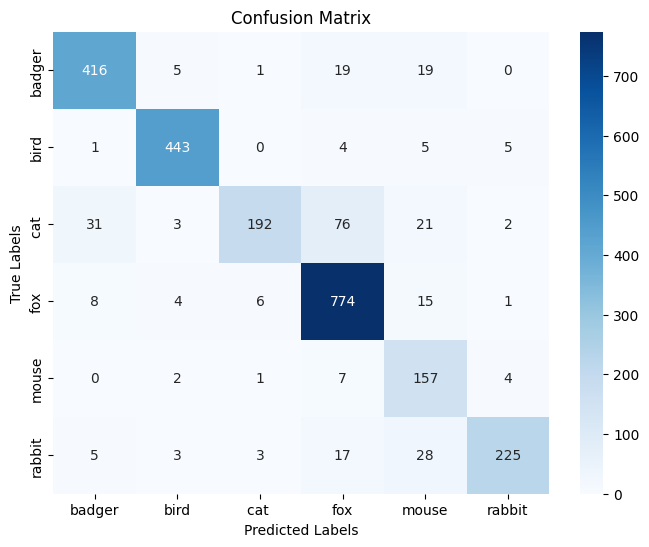

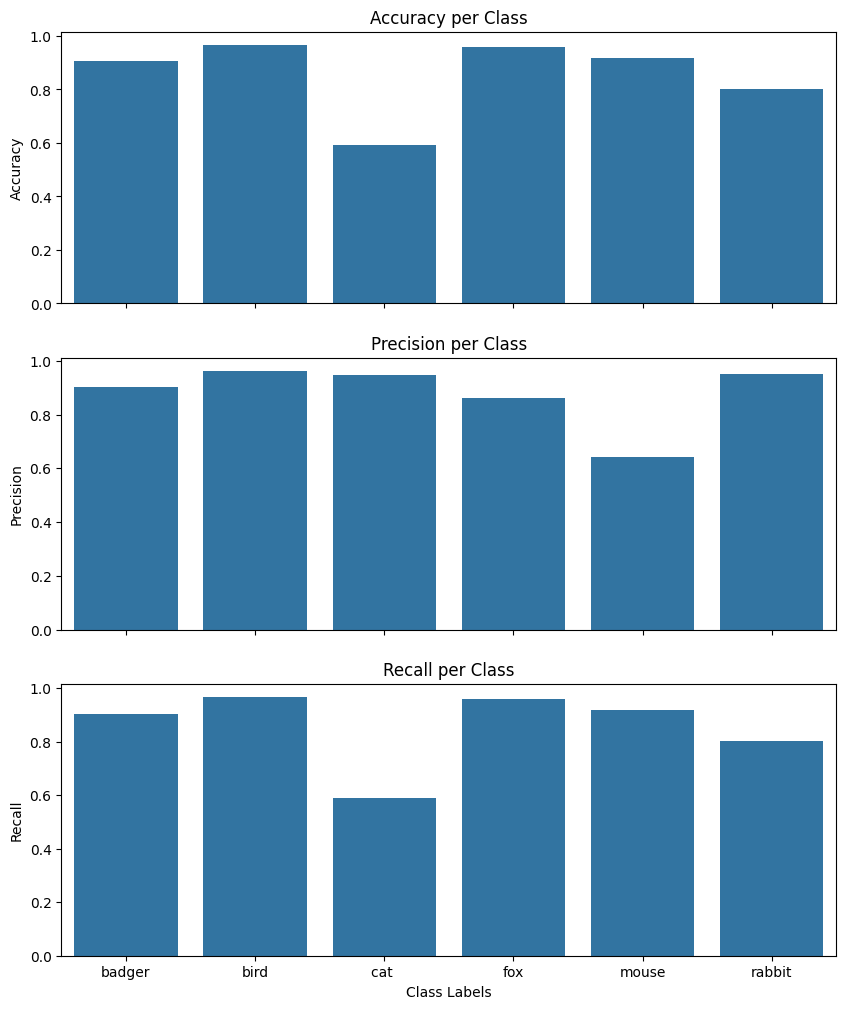

Total Accuracy: 0.88174190970835

Classification Report:
               precision    recall  f1-score   support

      badger       0.90      0.90      0.90       460
        bird       0.96      0.97      0.97       458
         cat       0.95      0.59      0.73       325
         fox       0.86      0.96      0.91       808
       mouse       0.64      0.92      0.75       171
      rabbit       0.95      0.80      0.87       281

    accuracy                           0.88      2503
   macro avg       0.88      0.86      0.85      2503
weighted avg       0.89      0.88      0.88      2503



In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'label_mapping' is a dictionary mapping class indices to class names
label_mapping = {0: 'badger', 1: 'bird', 2: 'cat ' , 3: 'fox', 4: 'mouse', 5: 'rabbit'}

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Display bar plots for accuracy, precision, and recall per class
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Accuracy per class
sns.barplot(x=label_mapping.values(), y=accuracy_per_class, ax=axes[0])
axes[0].set_title('Accuracy per Class')
axes[0].set_ylabel('Accuracy')

# Precision per class
sns.barplot(x=label_mapping.values(), y=precision_per_class, ax=axes[1])
axes[1].set_title('Precision per Class')
axes[1].set_ylabel('Precision')

# Recall per class
sns.barplot(x=label_mapping.values(), y=recall_per_class, ax=axes[2])
axes[2].set_title('Recall per Class')
axes[2].set_ylabel('Recall')

plt.xlabel('Class Labels')
plt.show()

# Print other metrics
print("Total Accuracy:", total_accuracy)
print("\nClassification Report:\n", class_report)